In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Restore the Conditional-DCGAN for MNIST and Generating images
Variable: noises, shape = (num of noise, 100)
          labels, shape = (num of noise, 10) in one hot
"""
def MNIST_Conditioinal_DCGAN_Generator(noises, labels):
    tf.reset_default_graph()
    
    #Restricted Settings#
    noise_size = 100
    generator_n_1 = 1024
    generator_n_2 = 512
    generator_n_3 = 256
    generator_n_4 = 128
    generator_n_out = 1
    discriminator_n_1 = 128
    discriminator_n_2 = 256
    discriminator_n_3 = 512
    discriminator_n_4 = 1024
    discriminator_n_out = 1
    image_H = 64
    image_W = 64
    image_C = 1
    label_size = 10
    
    #Define Generator#
    def generator(noises_input, labels_input, n_1, n_2, n_3, n_4, n_out, is_training):
        with tf.variable_scope('generator'):
            inputs = tf.concat([noises_input, labels_input], 1, name='inputs')
            Z1 = tf.contrib.layers.fully_connected(inputs, 4 * 4 * n_1, activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z1')
            Z1_reshape = tf.reshape(Z1, (-1, 4, 4, n_1), name='A1_reshape')
            Z1_bn = tf.layers.batch_normalization(Z1_reshape, training=is_training, name='Z1_bn')
            A1 = tf.nn.relu(Z1_bn, name='A1')
            Z2 = tf.contrib.layers.conv2d_transpose(A1, n_2, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z2')
            Z2_bn = tf.layers.batch_normalization(Z2, training=is_training, name='Z2_bn')
            A2 = tf.nn.relu(Z2_bn, name='A2')
            Z3 = tf.contrib.layers.conv2d_transpose(A2, n_3, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z3')
            Z3_bn = tf.layers.batch_normalization(Z3, training=is_training, name='Z3_bn')
            A3 = tf.nn.relu(Z3_bn, name='A3')
            Z4 = tf.contrib.layers.conv2d_transpose(A3, n_4, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z4')
            Z4_bn = tf.layers.batch_normalization(Z4, training=is_training, name='Z4_bn')
            A4 = tf.nn.relu(Z4_bn, name='A4')
            Z_out = tf.contrib.layers.conv2d_transpose(A4, n_out, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z_out')
            A_out = tf.nn.tanh(Z_out, name='A_out')
        return A_out
    
    #Define Discriminator#
    def discriminator(images_input, labels_input, image_H, image_W, label_size, n_1, n_2, n_3, n_4, n_out, is_training, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):
            inputs = tf.concat([images_input, tf.tile(tf.reshape(labels_input, (-1, 1, 1, label_size)), (1, image_H, image_W, 1))], 3, name='inputs')
            Z1 = tf.contrib.layers.conv2d(inputs, n_1, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z1')
            A1 = tf.nn.leaky_relu(Z1, name='A1')
            Z2 = tf.contrib.layers.conv2d(A1, n_2, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z2')
            Z2_bn = tf.layers.batch_normalization(Z2, training=is_training, name='Z2_bn')
            A2 = tf.nn.leaky_relu(Z2_bn, name='A2')
            Z3 = tf.contrib.layers.conv2d(A2, n_3, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z3')
            Z3_bn = tf.layers.batch_normalization(Z3, training=is_training, name='Z3_bn')
            A3 = tf.nn.leaky_relu(Z3_bn, name='A3')
            Z4 = tf.contrib.layers.conv2d(A3, n_4, 5, stride=2, padding='SAME', activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z4')
            Z4_bn = tf.layers.batch_normalization(Z4, training=is_training, name='Z4_bn')
            A4 = tf.nn.leaky_relu(Z4_bn, name='A4')
            A4_flatten = tf.contrib.layers.flatten(A4, scope='A4_flatten')
            Z_out = tf.contrib.layers.fully_connected(A4_flatten, n_out, activation_fn=None, weights_initializer=tf.random_normal_initializer(mean=0., stddev=0.02), scope='Z_out')
        return Z_out
    
    #Define placeholders#
    real_images = tf.placeholder(tf.float32, (None, image_H, image_W, image_C), name='real_images')
    noises_input = tf.placeholder(tf.float32, (None, noise_size), name='noises_input')
    labels_input = tf.placeholder(tf.float32, (None, label_size), name='labels_input')
    is_training = tf.placeholder(tf.bool, name='is_training')

    #Define the outputs of generator and discriminator#
    fake_images = generator(noises_input, labels_input, generator_n_1, generator_n_2, generator_n_3, generator_n_4, generator_n_out, is_training)
    real_logits = discriminator(real_images, labels_input, image_H, image_W, label_size, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_4, discriminator_n_out, is_training)
    fake_logits = discriminator(fake_images, labels_input, image_H, image_W, label_size, discriminator_n_1, discriminator_n_2, discriminator_n_3, discriminator_n_4, discriminator_n_out, is_training, reuse=True)

    #Generate Images#
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    saver = tf.train.Saver()
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, './MNIST_Conditional-DCGAN_model.ckpt')
        generated_images = sess.run(fake_images, feed_dict={noises_input:noises, labels_input:labels, is_training:False})
    return generated_images

In [3]:
noises = np.repeat(np.random.uniform(low=-1, high=1, size=(10, 100)), 10, axis=0)
labels = np.tile(np.eye(10), (10, 1))
generated_images = MNIST_Conditioinal_DCGAN_Generator(noises, labels)

INFO:tensorflow:Restoring parameters from ./MNIST_Conditional-DCGAN_model.ckpt


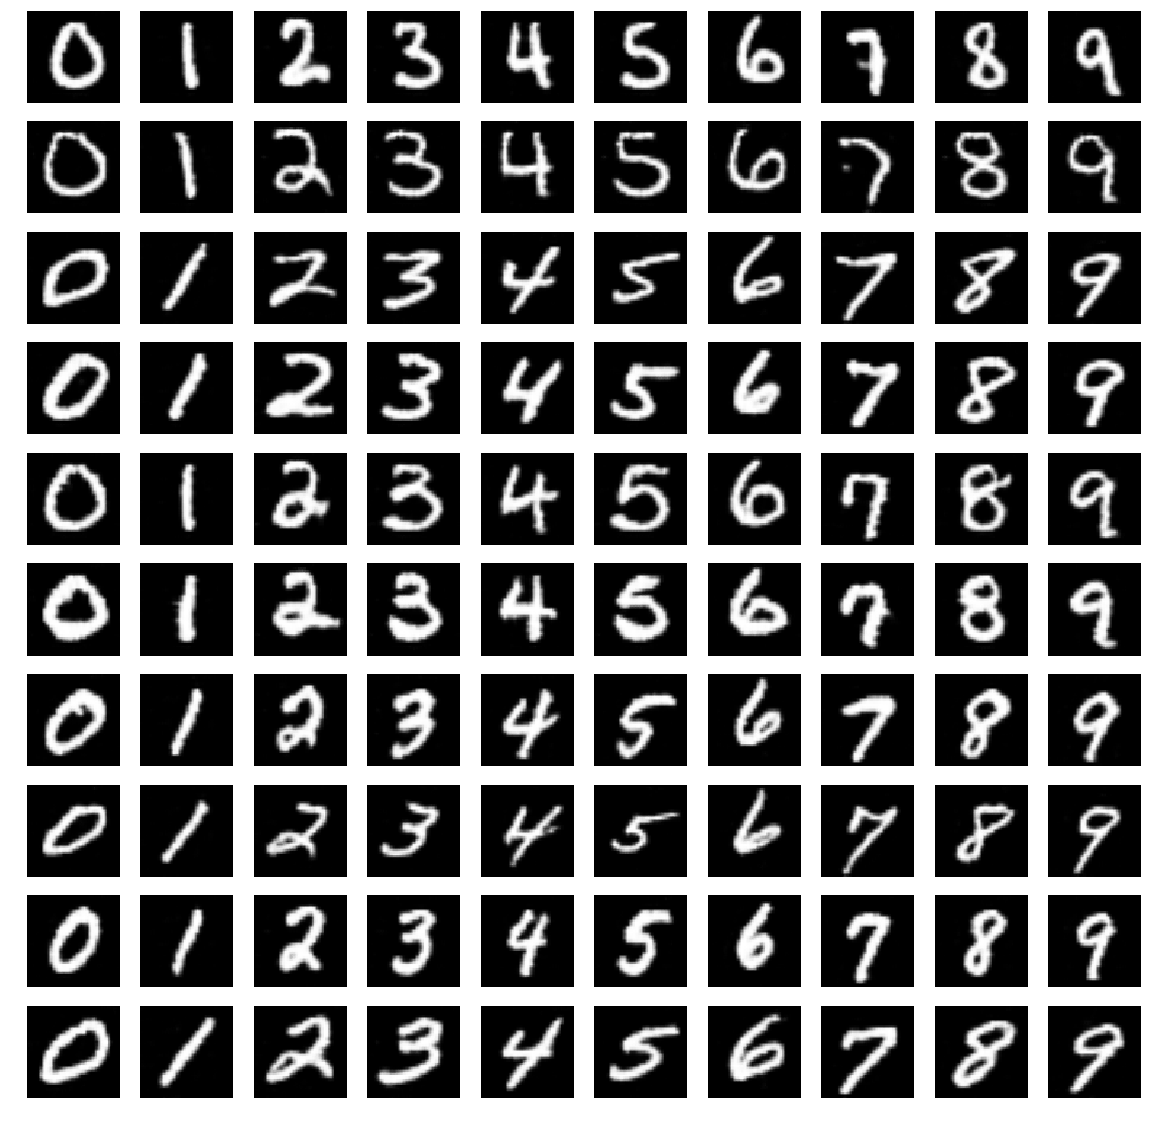

In [4]:
plt.figure(figsize=(20, 20))
for i in range(1, 101):
    plt.subplot(10, 10, i)
    plt.axis('off')
    plt.imshow(generated_images[i - 1].reshape(64, 64), cmap='gray')
plt.show()